# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data (Business Understanding Phase)

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

***Answer:*** According to the paper, the data represent **17** marketing campaigns: "The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts."

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8" # To eliminate warning when trying to find number of physical cores

import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [2]:
# Read the full dataset provided
df_full = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
# Examine the data
df_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features (Data Understanding Phase)


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



First, let's look at the data types, and at the same time, look for null values in the data fields:

In [4]:
# Examine the data for missing values and data types
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

From these results, it looks like there aren't any missing (null values). However the categorical fields of Dtype "object" will need to be encoded with either ordinal or nominal encoding in order to be used for modelling, so we'll want to look at whether there are valid (i.e. not 'unknown') values for these fields, to consider dropping rows with unknown values during the Data Preparation phase. We also need to check for outliers in the 'age' field.

From the descriptions given it's also clear that many the fields have values that were added after the initial contact was made. None of these features should be included in the training dataset, because they contain data that won't be available to the model when making predictions about which initial contacts will be successful. Also, the fields containing social and economic data are only useful for comparing results across different periods of time, so they won't be useful for prediction at a given point in time, and should also be excluded. So ultimately it looks like only the "bank client data" fields (columns 1 through 7), as well as the output target y, should be included in the training data.

First let's look at the 'age' field distribution:

In [5]:
# Show the distribution of 'age' values
print(df_full['age'].describe())

count    41188.00000
mean        40.02406
std         10.42125
min         17.00000
25%         32.00000
50%         38.00000
75%         47.00000
max         98.00000
Name: age, dtype: float64


This distribution looks reasonable. During Data Preparation these values will be standardized.

Next, let's look at the distribution of values in the remaining fields of interest, to see how many of them contain 'unknown' as their value:

In [6]:
# Show the value counts in each of the categorical fields of interest
print(df_full['job'].value_counts())
print()
print(df_full['marital'].value_counts())
print()
print(df_full['education'].value_counts())
print()
print(df_full['default'].value_counts())
print()
print(df_full['housing'].value_counts())
print()
print(df_full['loan'].value_counts())
print()
print(df_full['y'].value_counts())

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64

y
no     36548
yes     4640
Name: count, dtype: int64


In order to reduce the total number of features and make the best predictive model, we will want to remove all the rows that have the value 'unknown' in the categorical fields of interest. From the results above, it looks like the only field with a significant portion of 'unknown' values (i.e. greater than 5%) is 'default', so we will keep the 'unknown' values for that field and encode them as a separate category. However all the other rows with 'unknown' will be dropped. This will be especially helpful for the 'education' field, because the remaining values for that field have a natural order to them and can be encoded with ordinal encoding rather than one-hot encoding. Dropping the 'unknown' values will also reduce the number of categories for 'housing' and 'loan' to 2, making it possible to encode those fields (along with the output field 'y') with a single binary value (0 for 'no' and 1 for 'yes').

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

***Answer:*** The business objective of this task is to produce a model that can predict whether an initial contact of a bank client will ultimately be successful in producing a term deposit, based on client data known to the bank at the time of the prediction, so that bank employees can conduct a directed marking campaign to target only those individuals who are most likely to subscribe to a deposit, in order to cut costs and produce more revenue for the bank.

### Problem 5: Engineering Features (Data Preparation Phase)

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

#### 5.1 Drop Unwanted Rows
First, as noted above, we will drop all the rows with 'unknown' in the categorical fields of interest (with the exception of 'default', which has too many unknown values to drop):

In [7]:
# Create a data copy to preserve the raw data
df_filtered = df_full.copy()

# Drop rows with 'unknown' in any of the categorical fields of interest, except 'default'
df_filtered = df_filtered[df_filtered['job']       != 'unknown']
df_filtered = df_filtered[df_filtered['marital']   != 'unknown']
df_filtered = df_filtered[df_filtered['education'] != 'unknown']
df_filtered = df_filtered[df_filtered['housing']   != 'unknown']
df_filtered = df_filtered[df_filtered['loan']      != 'unknown']

Now that all the rows have been dropped, let's reset the index so it doesn't have any gaps, and check how many rows remain:

In [8]:
# Reset the index to start at zero, without any gaps
df_filtered = df_filtered.reset_index(drop = True)

# Show the size of the filtered data set
print(df_filtered.shape)

(38245, 21)


We've lost 2,943 rows, or 7.15% of the original data. This seems acceptable.
Now let's double-check that the filtering removed all the unwanted rows:

In [9]:
# Show the value counts in each of the categorical fields of interest
print(df_filtered['job'].value_counts())
print()
print(df_filtered['marital'].value_counts())
print()
print(df_filtered['education'].value_counts())
print()
print(df_filtered['default'].value_counts())
print()
print(df_filtered['housing'].value_counts())
print()
print(df_filtered['loan'].value_counts())
print()
print(df_filtered['y'].value_counts())

job
admin.           9937
blue-collar      8560
technician       6380
services         3716
management       2728
retired          1577
entrepreneur     1360
self-employed    1349
housemaid         987
unemployed        963
student           688
Name: count, dtype: int64

marital
married     23183
single      10760
divorced     4302
Name: count, dtype: int64

education
university.degree      11821
high.school             9244
basic.9y                5856
professional.course     5100
basic.4y                4002
basic.6y                2204
illiterate                18
Name: count, dtype: int64

default
no         30485
unknown     7757
yes            3
Name: count, dtype: int64

housing
yes    20578
no     17667
Name: count, dtype: int64

loan
no     32286
yes     5959
Name: count, dtype: int64

y
no     33987
yes     4258
Name: count, dtype: int64


All the unknown values have been removed, except for those in the 'default' field.

#### 5.2 Drop Unwanted Columns
Now we will drop all but the seven input columns of interest and the output column.

In [10]:
# Drop all the unwanted columns
df_filtered = df_filtered[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'y']]

Let's check the remaining data:

In [11]:
df_filtered.head()

,age,job,marital,education,default,housing,loan,y
0,56,housemaid,married,basic.4y,no,no,no,no
1,57,services,married,high.school,unknown,no,no,no
2,37,services,married,high.school,no,yes,no,no
3,40,admin.,married,basic.6y,no,no,no,no
4,56,services,married,high.school,no,no,yes,no


In [12]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38245 entries, 0 to 38244
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        38245 non-null  int64 
 1   job        38245 non-null  object
 2   marital    38245 non-null  object
 3   education  38245 non-null  object
 4   default    38245 non-null  object
 5   housing    38245 non-null  object
 6   loan       38245 non-null  object
 7   y          38245 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.3+ MB


#### 5.3 Encode Ordinal Data in Education Field
The 'education' field will now be encoded with the seven ordinal values in the following order:<br>
'illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree'

In [13]:
# Create a data copy to preserve the filtered data
df_encoded = df_filtered.copy()

# Encode the 'education' field with ordinal values
df_encoded['education'] = OrdinalEncoder(categories = [['illiterate',
                                                        'basic.4y',
                                                        'basic.6y',
                                                        'basic.9y',
                                                        'high.school',
                                                        'professional.course',
                                                        'university.degree']]
                                                     ).fit_transform(df_filtered[['education']])

Let's confirm that the ordinal encoding was successful:

In [14]:
# Show results of ordinal encoding
print(df_encoded['education'].value_counts())
df_encoded.head()

education
6.0    11821
4.0     9244
3.0     5856
5.0     5100
1.0     4002
2.0     2204
0.0       18
Name: count, dtype: int64


,age,job,marital,education,default,housing,loan,y
0,56,housemaid,married,1.0,no,no,no,no
1,57,services,married,4.0,unknown,no,no,no
2,37,services,married,4.0,no,yes,no,no
3,40,admin.,married,2.0,no,no,no,no
4,56,services,married,4.0,no,no,yes,no


#### 5.4 Encode Categorical Fields Containing Nominal Data
Now we'll encode the remaining categorical fields with nominal data.<br>
The following fields will be encoded with one-hot encoding:
- 'job', with 11 dummy features
- 'marital', with 3 dummy features
- 'default', with 3 dummy features

And the following fields with only 'no' and 'yes' values will be encoded as binary values ('no' = 0 and 'yes' = 1):
- 'housing'
- 'loan'
- 'y'

In [15]:
# Add 11 dummy features for the 'job' field and remove the original field
dummies    = pd.get_dummies(df_encoded['job'], prefix = 'job', dtype = float)
df_encoded = pd.concat([df_encoded, dummies], axis = 1)
df_encoded = df_encoded.drop('job', axis = 1)

# Add 3 dummy features for the 'marital' field and remove the original field
dummies    = pd.get_dummies(df_encoded['marital'], prefix = 'marital', dtype = float)
df_encoded = pd.concat([df_encoded, dummies], axis = 1)
df_encoded = df_encoded.drop('marital', axis = 1)

# Add 3 dummy features for the 'default' field and remove the original field
dummies    = pd.get_dummies(df_encoded['default'], prefix = 'default', dtype = float)
df_encoded = pd.concat([df_encoded, dummies], axis = 1)
df_encoded = df_encoded.drop('default', axis = 1)

# Convert the binary 'housing' field to 0 for 'no' and 1 for 'yes'
df_encoded['housing'] = np.where(df_encoded['housing'] == 'yes', 1, 0)

# Convert the binary 'loan' field to 0 for 'no' and 1 for 'yes'
df_encoded['loan'] = np.where(df_encoded['loan'] == 'yes', 1, 0)

# Convert the binary 'y' field to 0 for 'no' and 1 for 'yes'
df_encoded['y'] = np.where(df_encoded['y'] == 'yes', 1, 0)

Let's confirm that the nominal encoding was successful:

In [16]:
df_encoded.head()

,age,education,housing,loan,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,default_no,default_unknown,default_yes
0,56,1.0,0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,57,4.0,0,0,0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,4.0,1,0,0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,40,2.0,0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,56,4.0,0,1,0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [17]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38245 entries, 0 to 38244
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                38245 non-null  int64  
 1   education          38245 non-null  float64
 2   housing            38245 non-null  int64  
 3   loan               38245 non-null  int64  
 4   y                  38245 non-null  int64  
 5   job_admin.         38245 non-null  float64
 6   job_blue-collar    38245 non-null  float64
 7   job_entrepreneur   38245 non-null  float64
 8   job_housemaid      38245 non-null  float64
 9   job_management     38245 non-null  float64
 10  job_retired        38245 non-null  float64
 11  job_self-employed  38245 non-null  float64
 12  job_services       38245 non-null  float64
 13  job_student        38245 non-null  float64
 14  job_technician     38245 non-null  float64
 15  job_unemployed     38245 non-null  float64
 16  marital_divorced   382

#### 5.5 Standardize the Data
Finally, let's standardize the numerical fields 'age' and 'education' so they have a mean of 0 and a standard deviation of 1. The encoded binary and nominal fields will be left as is:

In [18]:
# Create a data copy to preserve the encoded data
df_standardized = df_encoded.copy()

# Create the standard scaler and scale the numerical fields 'age' and 'education'
scaler = StandardScaler()
df_standardized[["age", "education"]] = scaler.fit_transform(df_standardized[["age", "education"]])

# Show the scaled data to confirm the result
df_standardized.describe()

,age,education,housing,loan,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,default_no,default_unknown,default_yes
count,3.824500e+04,3.824500e+04,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,...,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000,38245.000000
mean,-2.690197e-16,2.259171e-16,0.538057,0.155811,0.111335,0.259825,0.223820,0.035560,0.025807,0.071330,...,0.097163,0.017989,0.166819,0.025180,0.112485,0.606171,0.281344,0.797098,0.202824,0.000078
std,1.000013e+00,1.000013e+00,0.498556,0.362681,0.314550,0.438544,0.416808,0.185193,0.158562,0.257378,...,0.296184,0.132914,0.372819,0.156673,0.315967,0.488604,0.449661,0.402166,0.402108,0.008856
min,-2.221799e+00,-2.548166e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-7.639810e-01,-7.137839e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,-1.808540e-01,-1.023232e-01,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,6.938365e-01,1.120598e+00,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,5.650416e+00,1.120598e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's also look at some sample data:

In [19]:
df_standardized.head()

,age,education,housing,loan,y,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,default_no,default_unknown,default_yes
0,1.568527,-1.936705,0,0,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.665715,-0.102323,0,0,0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,-0.278042,-0.102323,1,0,0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.013522,-1.325245,0,0,0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,1.568527,-0.102323,0,1,0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


#### 5.6 Separate the Dependent Variable
Now it's time to separate the dependent variable (y) from the independent variables (X):

In [20]:
X = df_standardized.drop('y', axis = 1)
y = df_standardized['y']

Let's confirm that this was done correctly:

In [21]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (38245, 21)
y shape: (38245,)


### Problem 6: Train/Test Split (Data Preparation Phase, continued)

With your data prepared, split it into a train and test set.

In [22]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

# Confirm the train and test set sizes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape:  {y_test.shape}")

X_train shape: (28683, 21)
X_test shape:  (9562, 21)
y_train shape: (28683,)
y_test shape:  (9562,)


### Problem 7: A Baseline Model (Modeling Phase)

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

First, let's look at the number of test set samples in each category (0 for 'no' and 1 for 'yes'):

In [23]:
# Display the test set output category counts
print(y_test.value_counts())

y
0    8487
1    1075
Name: count, dtype: int64


Our best choice for the baseline or "dummy" model depends on the performance metric that is most important to us. If we only care about the accuracy of our predictions, then we should chose a baseline model for which the predicted output y is always 0 (for 'no'), because that is the more prevalant value. However for this task, we might consider it more important to avoid false negatives (customers who would have subscribed to a deposit but weren't contacted) than the overall accuracy of the predictions. In this case we would chose a "dummy" model that always predicts 1 (for 'yes'), to make sure that we always contact a customer who will subscribe. Such a model will have a perfect Recall score, but a poor Precision score, so improvements to the model (over baseline) should be measured by the F1 score, which balances the Recall and Precision scores.

We will consider both possible dummy models, but going forward, given the nature of this prediction problem (contacting customers who will subscribe), we will consider the F1 score to be of greater interest.

Below, the performances of these two baseline models (accuracy, precision, recall, and F1) are calculated and reported as the first two rows in a DataFrame of results that we will build to show the performances of the various models in this assignment.

In [24]:
# Build a dummy model that always predicts "no" (the most frequent output)
model_dummy_no = DummyClassifier(strategy="most_frequent")
start_time = time.perf_counter()
model_dummy_no.fit(X_train, y_train)
train_time = time.perf_counter() - start_time

# Predict y with this model and create the first row in the table of results
y_pred_train = model_dummy_no.predict(X_train)
y_pred_test  = model_dummy_no.predict(X_test)
results = {
    "Model":          "Dummy (always no)",
    "Train Time":     train_time,
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Test Accuracy":  accuracy_score(y_test, y_pred_test),
    "Test Precision": precision_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test Recall":    recall_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test F1":        f1_score(y_test, y_pred_test, pos_label=1, zero_division=0),
}

# Create a DataFrame with these results and display it
df_results = pd.DataFrame([results]).set_index("Model")
df_results

,Train Time,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,,,
Dummy (always no),0.003044,0.889028,0.887576,0.0,0.0,0.0


Note that while test accuracy for this Dummy model is 88.8%, the precision, recall, and F1 scores of 0% tell the true story - that 'yes' is never predicted by this baseline model.

In [25]:
# Build a dummy model that always predicts "yes" (to avoid false negatives)
model_dummy_yes = DummyClassifier(strategy='constant', constant=1)
start_time = time.perf_counter()
model_dummy_yes.fit(X_train, y_train)
train_time = time.perf_counter() - start_time

# Predict y with this model and add a row to the table of results
y_pred_train = model_dummy_yes.predict(X_train)
y_pred_test  = model_dummy_yes.predict(X_test)
results = {
    "Model":          "Dummy (always yes)",
    "Train Time":     train_time,
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Test Accuracy":  accuracy_score(y_test, y_pred_test),
    "Test Precision": precision_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test Recall":    recall_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test F1":        f1_score(y_test, y_pred_test, pos_label=1, zero_division=0),
}
df_results = pd.concat([df_results, pd.DataFrame([results]).set_index("Model")], axis=0)

# Display the results
df_results

,Train Time,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,,,
Dummy (always no),0.003044,0.889028,0.887576,0.000000,0.0,0.000000
Dummy (always yes),0.002915,0.110972,0.112424,0.112424,1.0,0.202125


This second Dummy model only has a test accuracy of 11.2%, but it has perfect Recall (as expected) and an F1 score of 0.202, which will be the number to beat.

### Problem 8: A Simple Model (Modeling Phase, continued)

Use Logistic Regression to build a basic model on your data.  

In [26]:
# Build and train a Logistic Regression model
model_logreg = LogisticRegression(max_iter=1000)
start_time = time.perf_counter()
model_logreg.fit(X_train, y_train)
train_time = time.perf_counter() - start_time

### Problem 9: Score the Model (Modeling Phase, continued)

What is the accuracy of your model?

In [27]:
# Predict y with this model and add a row to the table of results
y_pred_train = model_logreg.predict(X_train)
y_pred_test  = model_logreg.predict(X_test)
results = {
    "Model":          "Logistic Regression (default)",
    "Train Time":     train_time,
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Test Accuracy":  accuracy_score(y_test, y_pred_test),
    "Test Precision": precision_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test Recall":    recall_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test F1":        f1_score(y_test, y_pred_test, pos_label=1, zero_division=0),
}
df_results = pd.concat([df_results, pd.DataFrame([results]).set_index("Model")], axis=0)

# Display the results
df_results

,Train Time,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,,,
Dummy (always no),0.003044,0.889028,0.887576,0.000000,0.0,0.000000
Dummy (always yes),0.002915,0.110972,0.112424,0.112424,1.0,0.202125
Logistic Regression (default),0.190556,0.889028,0.887576,0.000000,0.0,0.000000


It appears that the basic Logistic Regression model doesn't do any better than the first Dummy model, and is only predicting 'no' outcomes. This is probably due to the fact that the model is using the default probability threshold of 0.5 for 'yes' outcomes, which isn't exceeded for any of the test samples. Let's check this by looking at the maximum and mean probabilities produced by the model on the test set:

In [28]:
# Show the maximum and mean probabilities produced by the Logistic Regression model on the test set
p = model_logreg.predict_proba(X_test)[:, 1]
print(p.max(), p.mean())

0.4225962771323042 0.11024525307288201


As suspected, the highest probability produced by the model on the test set falls below 0.5, so no 'yes' predictions were made. Hopefully this model will do better when we start tuning the hyperparameters in the last part of this assignment.

### Problem 10: Model Comparisons (Modeling Phase, continued)

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

#### 10.1 K Nearest Neighbors
Let's address these three additional models one at a time. First, the K Nearest Neighbors classifier, with default settings:

In [29]:
# Build and train a K Nearest Neighbors model with default parameters
model_knn = KNeighborsClassifier()
start_time = time.perf_counter()
model_knn.fit(X_train, y_train)
train_time = time.perf_counter() - start_time

# Predict y with this model and add a row to the table of results
y_pred_train = model_knn.predict(X_train)
y_pred_test  = model_knn.predict(X_test)
results = {
    "Model":          "KNN (default)",
    "Train Time":     train_time,
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Test Accuracy":  accuracy_score(y_test, y_pred_test),
    "Test Precision": precision_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test Recall":    recall_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test F1":        f1_score(y_test, y_pred_test, pos_label=1, zero_division=0),
}
df_results = pd.concat([df_results, pd.DataFrame([results]).set_index("Model")], axis=0)

# Display the results
df_results

,Train Time,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,,,
Dummy (always no),0.003044,0.889028,0.887576,0.000000,0.000000,0.000000
Dummy (always yes),0.002915,0.110972,0.112424,0.112424,1.000000,0.202125
Logistic Regression (default),0.190556,0.889028,0.887576,0.000000,0.000000,0.000000
KNN (default),0.011892,0.891260,0.878791,0.325000,0.072558,0.118631


The default KNN algorithm appears to be classifying some test samples as 'yes', but the overall accuracy of these predictions is no better (and in fact is a little worse) than if it just classified everything as 'no', and the F1 score is worse than if we classified everything as 'yes'. Again, we'll need to try different hyperparameters for this model to see if we can improve it.

#### 10.2 Decision Tree
Next, let's try a Decision Tree classifier, with default settings:

In [30]:
# Build and train a Decision Tree model with default parameters
model_tree = DecisionTreeClassifier()
start_time = time.perf_counter()
model_tree.fit(X_train, y_train)
train_time = time.perf_counter() - start_time

# Predict y with this model and add a row to the table of results
y_pred_train = model_tree.predict(X_train)
y_pred_test  = model_tree.predict(X_test)
results = {
    "Model":          "Decision Tree (default)",
    "Train Time":     train_time,
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Test Accuracy":  accuracy_score(y_test, y_pred_test),
    "Test Precision": precision_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test Recall":    recall_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test F1":        f1_score(y_test, y_pred_test, pos_label=1, zero_division=0),
}
df_results = pd.concat([df_results, pd.DataFrame([results]).set_index("Model")], axis=0)

# Display the results
df_results

,Train Time,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,,,
Dummy (always no),0.003044,0.889028,0.887576,0.000000,0.000000,0.000000
Dummy (always yes),0.002915,0.110972,0.112424,0.112424,1.000000,0.202125
Logistic Regression (default),0.190556,0.889028,0.887576,0.000000,0.000000,0.000000
KNN (default),0.011892,0.891260,0.878791,0.325000,0.072558,0.118631
Decision Tree (default),0.109257,0.914095,0.871157,0.287263,0.098605,0.146814


As with the default KNN classifier, the default Decision Tree classifier is also classifying some test samples as 'yes', but again the overall accuracy of these predictions is a little worse than if it just classified everything as 'no', and the F1 score is worse than if we classified everything as 'yes'. Different hyperparameters will be tried for this model as well to see if we can improve it.

#### 10.3 Support Vector Machine
Finally, we'll try an SVM classifier, with default settings. This takes a little while to run (about 1 minute on my machine):

In [31]:
# Build and train an SVM model with default parameters
model_svm = SVC()
start_time = time.perf_counter()
model_svm.fit(X_train, y_train)
train_time = time.perf_counter() - start_time

# Predict y with this model and add a row to the table of results
y_pred_train = model_svm.predict(X_train)
y_pred_test  = model_svm.predict(X_test)
results = {
    "Model":          "SVM (default)",
    "Train Time":     train_time,
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Test Accuracy":  accuracy_score(y_test, y_pred_test),
    "Test Precision": precision_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test Recall":    recall_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test F1":        f1_score(y_test, y_pred_test, pos_label=1, zero_division=0),
}
df_results = pd.concat([df_results, pd.DataFrame([results]).set_index("Model")], axis=0)

# Display the results
df_results

,Train Time,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,,,
Dummy (always no),0.003044,0.889028,0.887576,0.000000,0.000000,0.000000
Dummy (always yes),0.002915,0.110972,0.112424,0.112424,1.000000,0.202125
Logistic Regression (default),0.190556,0.889028,0.887576,0.000000,0.000000,0.000000
KNN (default),0.011892,0.891260,0.878791,0.325000,0.072558,0.118631
Decision Tree (default),0.109257,0.914095,0.871157,0.287263,0.098605,0.146814
SVM (default),39.612145,0.889028,0.887576,0.000000,0.000000,0.000000


The default SVM classifier performs like the default Logistic Regression classifier, producing only 'no' predictions on the test set. This is one more model to be tuned with different hyperparameters to try to improve it.

### Problem 11: Improving the Model (Modeling Phase, continued)

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

As noted above, F1 will be the metric used to evaluate the performance of the models as we try to improve them by tuning the hyperparameters in a grid search. For the grid search, we'll randomize 5 folds to make sure that any existing order in the entries is removed. Each of the four classification models will be tuned in the sections below.

#### 11.1 Logistic Regression
We'll start by tuning the hyperparameters for the Logistic Regression classifier:

In [32]:
# Set the grid search parameters for the Logistic Regression classifier
params_logreg = {
    "C":            [0.01, 0.1, 1, 10, 100],
    "class_weight": [None, "balanced"],
    "solver":       ["lbfgs", "liblinear"],
}

# Build the grid search to tune the hyperparameters
grid_model_logreg = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid=params_logreg,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1
)

# Perform the grid search and print the best parameters
start_time = time.perf_counter()
grid_model_logreg.fit(X_train, y_train)
train_time = time.perf_counter() - start_time
print(f"Logistic Regression best parameters: {grid_model_logreg.best_params_}")

# Predict y with the best model and add a row to the table of results
y_pred_train = grid_model_logreg.predict(X_train)
y_pred_test  = grid_model_logreg.predict(X_test)
results = {
    "Model":          "Logistic Regression (tuned)",
    "Train Time":     train_time,
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Test Accuracy":  accuracy_score(y_test, y_pred_test),
    "Test Precision": precision_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test Recall":    recall_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test F1":        f1_score(y_test, y_pred_test, pos_label=1, zero_division=0),
}
df_results = pd.concat([df_results, pd.DataFrame([results]).set_index("Model")], axis=0)

# Display the results
df_results

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Logistic Regression best parameters: {'C': 100, 'class_weight': 'balanced', 'solver': 'liblinear'}


,Train Time,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,,,
Dummy (always no),0.003044,0.889028,0.887576,0.000000,0.000000,0.000000
Dummy (always yes),0.002915,0.110972,0.112424,0.112424,1.000000,0.202125
Logistic Regression (default),0.190556,0.889028,0.887576,0.000000,0.000000,0.000000
KNN (default),0.011892,0.891260,0.878791,0.325000,0.072558,0.118631
Decision Tree (default),0.109257,0.914095,0.871157,0.287263,0.098605,0.146814
SVM (default),39.612145,0.889028,0.887576,0.000000,0.000000,0.000000
Logistic Regression (tuned),9.081124,0.570024,0.573834,0.156593,0.636279,0.251332


#### 11.2 K Nearest Neighbors
Next we'll tune the K Nearest Neighbors classifier:

In [33]:
# Set the grid search parameters for the K Nearest Neighbors classifier
params_knn = {
    "n_neighbors": [3, 5, 7, 9, 11, 15, 21, 31],
    "weights":     ["uniform", "distance"],
    "p":           [1, 2],
}

# Build the grid search to tune the hyperparameters
grid_model_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid=params_knn,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1
)

# Perform the grid search and print the best parameters
start_time = time.perf_counter()
grid_model_knn.fit(X_train, y_train)
train_time = time.perf_counter() - start_time
print(f"KNN best parameters: {grid_model_knn.best_params_}")

# Predict y with the best model and add a row to the table of results
y_pred_train = grid_model_knn.predict(X_train)
y_pred_test  = grid_model_knn.predict(X_test)
results = {
    "Model":          "KNN (tuned)",
    "Train Time":     train_time,
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Test Accuracy":  accuracy_score(y_test, y_pred_test),
    "Test Precision": precision_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test Recall":    recall_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test F1":        f1_score(y_test, y_pred_test, pos_label=1, zero_division=0),
}
df_results = pd.concat([df_results, pd.DataFrame([results]).set_index("Model")], axis=0)

# Display the results
df_results

Fitting 5 folds for each of 32 candidates, totalling 160 fits
KNN best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


,Train Time,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,,,
Dummy (always no),0.003044,0.889028,0.887576,0.000000,0.000000,0.000000
Dummy (always yes),0.002915,0.110972,0.112424,0.112424,1.000000,0.202125
Logistic Regression (default),0.190556,0.889028,0.887576,0.000000,0.000000,0.000000
KNN (default),0.011892,0.891260,0.878791,0.325000,0.072558,0.118631
Decision Tree (default),0.109257,0.914095,0.871157,0.287263,0.098605,0.146814
SVM (default),39.612145,0.889028,0.887576,0.000000,0.000000,0.000000
Logistic Regression (tuned),9.081124,0.570024,0.573834,0.156593,0.636279,0.251332
KNN (tuned),36.556289,0.903532,0.861744,0.270019,0.134884,0.179901


#### 11.3 Decision Tree
Next is the Decision Tree classifier:

In [34]:
# Set the grid search parameters for the Decision Tree classifier
params_tree = {
    "max_depth":         [None, 3, 5, 8, 12, 20],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf":  [1, 2, 5, 10],
    "class_weight":      [None, "balanced"],
    "criterion":         ["gini", "entropy"],
}

# Build the grid search to tune the hyperparameters
grid_model_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=params_tree,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1
)

# Perform the grid search and print the best parameters
start_time = time.perf_counter()
grid_model_tree.fit(X_train, y_train)
train_time = time.perf_counter() - start_time
print(f"Decision Tree best parameters: {grid_model_tree.best_params_}")

# Predict y with the best model and add a row to the table of results
y_pred_train = grid_model_tree.predict(X_train)
y_pred_test  = grid_model_tree.predict(X_test)
results = {
    "Model":          "Decision Tree (tuned)",
    "Train Time":     train_time,
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Test Accuracy":  accuracy_score(y_test, y_pred_test),
    "Test Precision": precision_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test Recall":    recall_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test F1":        f1_score(y_test, y_pred_test, pos_label=1, zero_division=0),
}
df_results = pd.concat([df_results, pd.DataFrame([results]).set_index("Model")], axis=0)

# Display the results
df_results

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Decision Tree best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 20}


,Train Time,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,,,
Dummy (always no),0.003044,0.889028,0.887576,0.000000,0.000000,0.000000
Dummy (always yes),0.002915,0.110972,0.112424,0.112424,1.000000,0.202125
Logistic Regression (default),0.190556,0.889028,0.887576,0.000000,0.000000,0.000000
KNN (default),0.011892,0.891260,0.878791,0.325000,0.072558,0.118631
Decision Tree (default),0.109257,0.914095,0.871157,0.287263,0.098605,0.146814
SVM (default),39.612145,0.889028,0.887576,0.000000,0.000000,0.000000
Logistic Regression (tuned),9.081124,0.570024,0.573834,0.156593,0.636279,0.251332
KNN (tuned),36.556289,0.903532,0.861744,0.270019,0.134884,0.179901
Decision Tree (tuned),15.386683,0.638462,0.635955,0.163591,0.544186,0.251559


#### 11.4 Support Vector Machine
And finally we'll tune the SVM classifier. ***Warning:*** This takes a long time to run (about 5 minutes on my machine):

In [35]:
# Set the grid search parameters for the SVM classifier
params_svm = {
    "kernel":       ["rbf"],
    "gamma":        ["scale"],
    "C":            [1, 10],
    "class_weight": [None, "balanced"],
}

# Build the grid search to tune the hyperparameters
grid_model_svm = GridSearchCV(
    SVC(),
    param_grid=params_svm,
    scoring="f1",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    refit=True,
    verbose=1
)

# Perform the grid search and print the best parameters
start_time = time.perf_counter()
grid_model_svm.fit(X_train, y_train)
train_time = time.perf_counter() - start_time
print(f"SVM best parameters: {grid_model_svm.best_params_}")

# Predict y with the best model and add a row to the table of results
y_pred_train = grid_model_svm.predict(X_train)
y_pred_test  = grid_model_svm.predict(X_test)
results = {
    "Model":          "SVM (tuned)",
    "Train Time":     train_time,
    "Train Accuracy": accuracy_score(y_train, y_pred_train),
    "Test Accuracy":  accuracy_score(y_test, y_pred_test),
    "Test Precision": precision_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test Recall":    recall_score(y_test, y_pred_test, pos_label=1, zero_division=0),
    "Test F1":        f1_score(y_test, y_pred_test, pos_label=1, zero_division=0),
}
df_results = pd.concat([df_results, pd.DataFrame([results]).set_index("Model")], axis=0)

# Display the results
df_results

Fitting 5 folds for each of 4 candidates, totalling 20 fits
SVM best parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}


,Train Time,Train Accuracy,Test Accuracy,Test Precision,Test Recall,Test F1
Model,,,,,,
Dummy (always no),0.003044,0.889028,0.887576,0.000000,0.000000,0.000000
Dummy (always yes),0.002915,0.110972,0.112424,0.112424,1.000000,0.202125
Logistic Regression (default),0.190556,0.889028,0.887576,0.000000,0.000000,0.000000
KNN (default),0.011892,0.891260,0.878791,0.325000,0.072558,0.118631
Decision Tree (default),0.109257,0.914095,0.871157,0.287263,0.098605,0.146814
SVM (default),39.612145,0.889028,0.887576,0.000000,0.000000,0.000000
Logistic Regression (tuned),9.081124,0.570024,0.573834,0.156593,0.636279,0.251332
KNN (tuned),36.556289,0.903532,0.861744,0.270019,0.134884,0.179901
Decision Tree (tuned),15.386683,0.638462,0.635955,0.163591,0.544186,0.251559


#### 11.5 Conclusions
First let's look at these results in graphical form:

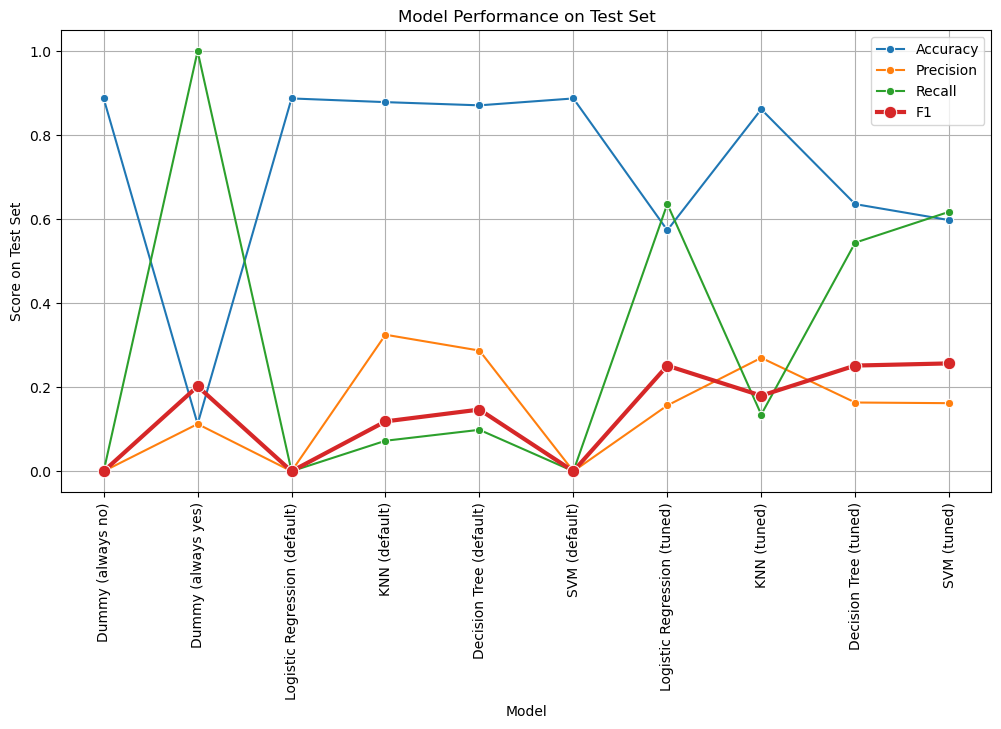

In [45]:
# Set the figure size
plt.figure(figsize = (12, 6))

# Plot the four performance metrics on the test set for all the models
sns.lineplot(df_results['Test Accuracy'],  label = 'Accuracy',  marker='o')
sns.lineplot(df_results['Test Precision'], label = 'Precision', marker='o')
sns.lineplot(df_results['Test Recall'],    label = 'Recall',    marker='o')
sns.lineplot(df_results['Test F1'],        label = 'F1',        marker='o', markersize=9, linewidth=3) # Make the F1 line thicker

# Add the title, axis labels, legend, and grid
plt.title("Model Performance on Test Set")
plt.xlabel("Model")
plt.ylabel("Score on Test Set")
plt.xticks(rotation = 90)
plt.legend()
plt.grid()

# Save the plot and show it
plt.savefig("images/ModelPerformance.png", bbox_inches="tight", dpi=300)
plt.show()

With tuned hyperparameters, three of the classifiers achieve about the same F1 score of 0.25: Logistic Regression, Decision Tree, and SVM. However the Decision Tree classifier has a lower Recall score than the other two (0.54 vs. 0.64 for Logistic Regression and 0.62 for SVM), and since the criterion of importance is probably to not miss out on customers who might subscribe to a deposit (i.e. fewer false negatives), Decision Trees will probably not be the best approach. Between Logistic Regression and SVM, Logistic Regression has the advantage of being faster to train, and it also has a slightly higher Recall score than SVM, so Logistic Regression comes out as the winner in this analysis, catching 64% of the actual positive cases in the test set, which represent only 11% of of the test set samples. It does so with 57% overall accuracy, which is pretty good considering the high Recall score.

Next, let's look at the coefficients in the tuned Logistic Regression model:

In [46]:
# Create a DataFrame with the features and coefficients of the best model
grid_model_logreg_best = grid_model_logreg.best_estimator_
df_coefficients = pd.DataFrame({
    'Feature'    : X_train.columns,
    'Coefficient': grid_model_logreg_best.coef_[0]
})

# Add a column for the absolute value of the coefficient and sort by it
df_coefficients['AbsCoefficient'] = abs(df_coefficients['Coefficient'])
df_coefficients = df_coefficients.sort_values('AbsCoefficient', ascending = False)

# Print all the coefficients to five decimal places
pd.set_option('display.float_format', '{:.5f}'.format)
with pd.option_context('display.max_rows', None):
    print(df_coefficients[['Feature', 'Coefficient']])
pd.reset_option('display.float_format')

              Feature  Coefficient
20        default_yes     -2.41679
18         default_no      1.27851
12        job_student      1.06852
9         job_retired      0.65438
6    job_entrepreneur     -0.54518
11       job_services     -0.44929
15   marital_divorced     -0.42924
5     job_blue-collar     -0.40399
19    default_unknown      0.36817
8      job_management     -0.34656
10  job_self-employed     -0.30142
16    marital_married     -0.28706
13     job_technician     -0.25362
7       job_housemaid     -0.16297
1           education      0.12329
0                 age      0.12141
4          job_admin.     -0.10957
3                loan     -0.09548
14     job_unemployed      0.07958
17     marital_single     -0.05380
2             housing      0.04799


And let's look at this graphically:

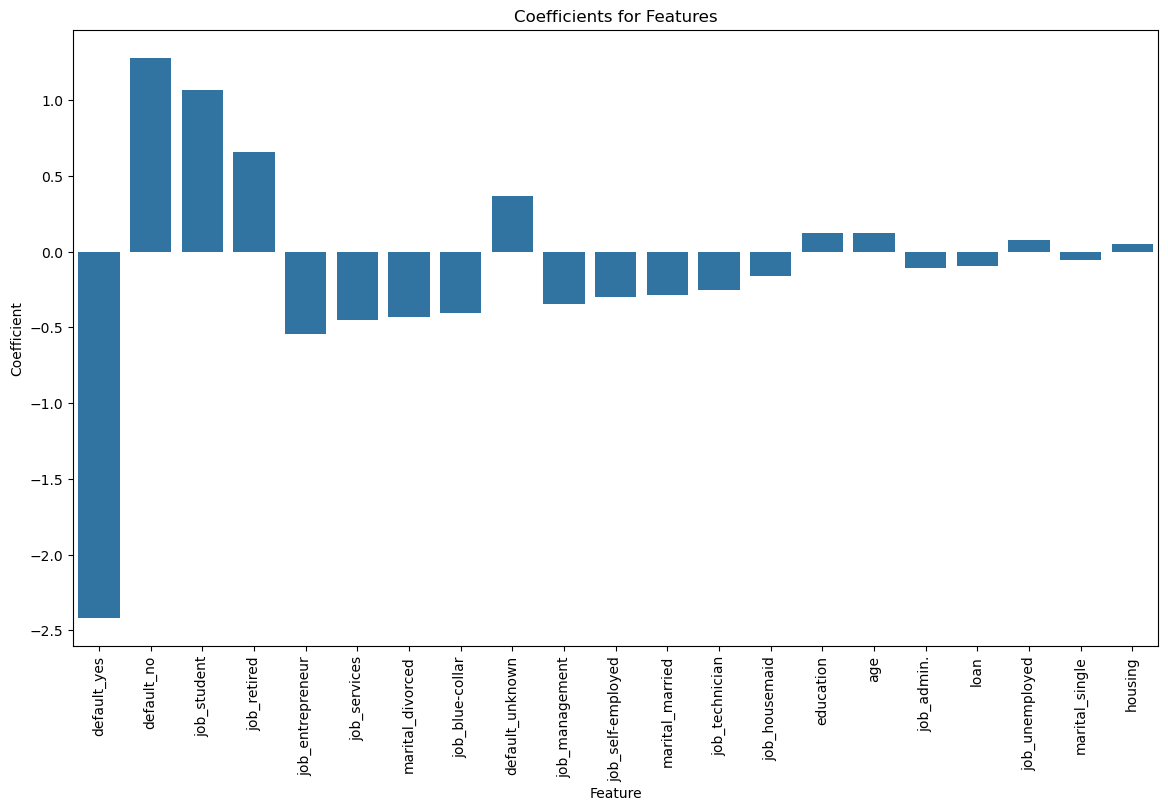

In [47]:
# Plot the coefficients for each feature
plt.figure(figsize = (14, 8))
sns.barplot(x = df_coefficients['Feature'], y = df_coefficients['Coefficient'])
plt.title("Coefficients for Features")
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.xticks(rotation = 90)
plt.show()

Not suprisingly, by far the most important feature that determines whether a customer will subscribe to a deposit is whether they have credit in default, with 'yes' resulting in less likelihood of subscribing than 'no'. The type of job the customer has is the next most important factor, with certain job categories (e.g. 'student' and 'retired') resulting in a much higher likelihood, and others (e.g. entrepreneur) resulting in a lower likelihood. Other factors, like education and age, seem to have less of an impact.

#### 11.6 Recommendations
As noted above, I recommend that the tuned Logistic Regression model be used for screening which individuals to contact, because eliminating false negatives (while not contacting every single individual) is of most importance, so the F1 score is the most important performance metric, and the tuned Logistic Regression model produces the best F1 score. Looking inside the tuned model, we see that contacting clients who have credit in default is probably not worthwhile, and clients who are students or are retired are better candidates to contact than those who are entrepreneurs.